In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.integrate import cumulative_trapezoid
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd  = 287.05
Rv  = 461.5
epsilon = Rd / Rv
Lv = 2.501e6

# --- Thermodynamic Functions ---
def saturation_vapor_pressure(T):
    T_c = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_c)/(T_c + 243.5))
    return es_hPa * 100.0  # Pa

def saturation_specific_humidity(p, T):
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denom = p - (1.0 - epsilon) * es
    qs = np.divide(epsilon * es, denom, out=np.full_like(p,1e-9), where=denom>0)
    return np.maximum(qs,1e-9)

def dqs_dT(p, T, dT=0.01):
    return (saturation_specific_humidity(p, T + dT)
          - saturation_specific_humidity(p, T - dT)) / (2*dT)

def dqs_dp(p, T, dp=10.0):
    return (saturation_specific_humidity(p + dp, T)
          - saturation_specific_humidity(p - dp, T)) / (2*dp)

def d2qs_dT2(p, T, dT=0.01):
    qs_p = saturation_specific_humidity(p, T + dT)
    qs_0 = saturation_specific_humidity(p, T)
    qs_m = saturation_specific_humidity(p, T - dT)
    return (qs_p - 2*qs_0 + qs_m) / (dT**2)

def d2qs_dTdp(p, T, dT=0.01, dp=10.0):
    dT_plus  = dqs_dT(p + dp, T, dT)
    dT_minus = dqs_dT(p - dp, T, dT)
    return (dT_plus - dT_minus) / (2*dp)

def virtual_temperature(T, p):
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1 + (1/epsilon - 1)*qs)
    return np.maximum(Tv,10.0)

def calculate_mse(T, p, z):
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv * qs

def calculate_profile_with_rootfinder(T_surf, p_surf, p_grid):
    n = len(p_grid)
    T_prof = np.full(n, np.nan)
    z_prof = np.full(n, np.nan)
    T_prof[0], z_prof[0] = T_surf, 0.0
    mse0 = calculate_mse(T_surf, p_grid[0], 0.0)

    for i in range(n-1):
        T_cur, p_cur, z_cur = T_prof[i], p_grid[i], z_prof[i]
        p_next = p_grid[i+1]
        if np.isnan(T_cur) or p_cur <= 0:
            break

        Tv = virtual_temperature(T_cur, p_cur)
        dz = - (Rd * Tv / p_cur) / g * (p_next - p_cur)
        z_next = z_cur + dz

        def resid(Tg):
            return calculate_mse(Tg, p_next, z_next) - mse0

        try:
            br = [150.0, T_cur + 5.0]
            if resid(br[0]) * resid(br[1]) > 0:
                break
            sol = root_scalar(resid, bracket=br, method='brentq', xtol=1e-3)
            if sol.converged:
                T_prof[i+1], z_prof[i+1] = sol.root, z_next
            else:
                break
        except:
            break

    return T_prof

print("--- Starting Main Calculation ---")
t0 = time.time()

# --- Grid setup ---
# Compute on expanded Ts domain to avoid left-edge artifacts
T_surf_vals = np.arange(279, 320.1, 1.0)    # expanded
Tmin_plot   = 280.0                       # visible lower bound
plot_mask   = T_surf_vals >= Tmin_plot    # columns to display

p_s, p_top, dp = 100000.0, 10000.0, -50.0
p_grid = np.arange(p_s, p_top + dp, dp)

n_p, n_t = len(p_grid), len(T_surf_vals)

# --- Storage for the 3 key fields ---
total_sens_grid = np.full((n_p, n_t), np.nan)
local_sens_grid = np.full((n_p, n_t), np.nan)
amp_factor_grid = np.full((n_p, n_t), np.nan)

for j, Ts in enumerate(T_surf_vals):
    print(f"Ts={Ts:.1f}K …", end='')
    Tprof = calculate_profile_with_rootfinder(Ts, p_s, p_grid)
    if np.isnan(Tprof[-1]):
        print(" fail"); continue

    # --- Local Thermodynamics (∂Γm/∂T) ---
    # Γm = N/D
    alpha_d = Rd * Tprof / p_grid
    cL      = Lv * dqs_dT(p_grid, Tprof)
    alpha_L = Lv * dqs_dp(p_grid, Tprof)
    
    N = alpha_d - alpha_L
    D = cpd + cL

    # Derivatives w.r.t local T
    # dN/dT and dD/dT
    dal_dT  = Lv * d2qs_dTdp(p_grid, Tprof)
    dcL_dT  = Lv * d2qs_dT2(p_grid, Tprof)
    
    dN = (Rd/p_grid) - dal_dT  # This is ∂N/∂T
    dD = dcL_dT              # This is ∂D/∂T
    
    # Apply quotient rule: ∂(N/D)/∂T = (D(∂N/∂T) - N(∂D/∂T)) / D²
    #                        = (1/D) * (∂N/∂T) - (N/D²) * (∂D/∂T)
    local_sens = (1.0/D)*dN - (N/(D**2))*dD  # This is ∂Γm/∂T

    # --- Amplification Factor ---
    # Integrate local sensitivity from surface (ps) to current level (p)
    # The integral is w.r.t 'p'
    integral_sens = cumulative_trapezoid(local_sens, x=p_grid, initial=0.0)
    amp_factor = np.exp(integral_sens)
    
    # --- Total Sensitivity (dΓm/dTs) ---
    # dΓm/dTs = (∂Γm/∂T) * Amplification
    total_sens = local_sens * amp_factor

    # Store results
    total_sens_grid[:, j] = total_sens
    local_sens_grid[:, j] = local_sens
    amp_factor_grid[:, j] = amp_factor

print(f"Done in {time.time() - t0:.1f}s")

# --- Ts-direction trough (Panel a): strictly zero of ∂f/∂Ts with positive curvature ---
# f = dγm/dTs = total_sens_grid
dT_mag   = np.abs(T_surf_vals[1] - T_surf_vals[0])
# Use total_sens_grid here
df_dTs   = np.gradient(total_sens_grid, dT_mag, axis=1)    # ∂f/∂Ts
d2f_dTs2 = np.gradient(df_dTs,  dT_mag, axis=1)          # ∂²f/∂Ts²

Ts_trough_root = np.full(n_p, np.nan)  # K

for i in range(n_p):
    row  = df_dTs[i, :]
    curv = d2f_dTs2[i, :]
    if np.sum(np.isfinite(row)) < 2:
        continue

    # Find NEG->POS sign changes (minima along Ts)
    neg_to_pos = (row[:-1] < 0) & (row[1:] > 0)
    k_all = np.where(neg_to_pos &
                     np.isfinite(row[:-1]) & np.isfinite(row[1:]))[0]

    # Filter by positive curvature near crossing
    Ts_candidates = []
    for k in k_all:
        T0, T1 = T_surf_vals[k], T_surf_vals[k+1]
        g0, g1 = row[k], row[k+1]
        if not np.isfinite(g0) or not np.isfinite(g1) or (g1 == g0):
            continue
        Ts_root = T0 - g0 * (T1 - T0) / (g1 - g0)
        curv_avg = 0.5 * (curv[k] + curv[k+1])
        if np.isfinite(curv_avg) and (curv_avg > 0):
            Ts_candidates.append(Ts_root)

    if Ts_candidates:
        # If multiple, choose nearest to the rowwise discrete min for stability
        # Use total_sens_grid here
        j0 = np.nanargmin(total_sens_grid[i, :])
        T0 = T_surf_vals[j0]
        Ts_trough_root[i] = min(Ts_candidates, key=lambda T: abs(T - T0))
    else:
        Ts_trough_root[i] = np.nan  # no valid root in-domain

# --- Ts-direction trough (Panel c): strictly zero of ∂g/∂Ts with positive curvature ---
# g = ∂γm/∂T = local_sens_grid
# Use local_sens_grid here
dg_dTs   = np.gradient(local_sens_grid, dT_mag, axis=1)    # ∂g/∂Ts
d2g_dTs2 = np.gradient(dg_dTs,  dT_mag, axis=1)          # ∂²g/∂Ts²

Ts_trough_root_local = np.full(n_p, np.nan)  # K

for i in range(n_p):
    row  = dg_dTs[i, :]
    curv = d2g_dTs2[i, :]
    if np.sum(np.isfinite(row)) < 2:
        continue

    # Find NEG->POS sign changes (minima along Ts)
    neg_to_pos = (row[:-1] < 0) & (row[1:] > 0)
    k_all = np.where(neg_to_pos &
                     np.isfinite(row[:-1]) & np.isfinite(row[1:]))[0]

    # Filter by positive curvature near crossing
    Ts_candidates = []
    for k in k_all:
        T0, T1 = T_surf_vals[k], T_surf_vals[k+1]
        g0, g1 = row[k], row[k+1]
        if not np.isfinite(g0) or not np.isfinite(g1) or (g1 == g0):
            continue
        Ts_root = T0 - g0 * (T1 - T0) / (g1 - g0)
        curv_avg = 0.5 * (curv[k] + curv[k+1])
        if np.isfinite(curv_avg) and (curv_avg > 0):
            Ts_candidates.append(Ts_root)

    if Ts_candidates:
        # If multiple, choose nearest to the rowwise discrete min for stability
        # Use local_sens_grid here
        j0 = np.nanargmin(local_sens_grid[i, :])
        T0 = T_surf_vals[j0]
        Ts_trough_root_local[i] = min(Ts_candidates, key=lambda T: abs(T - T0))
    else:
        Ts_trough_root_local[i] = np.nan  # no valid root in-domain


--- Starting Main Calculation ---
Ts=279.0K …Ts=280.0K …Ts=281.0K …Ts=282.0K …Ts=283.0K …Ts=284.0K …Ts=285.0K …Ts=286.0K …Ts=287.0K …Ts=288.0K …Ts=289.0K …Ts=290.0K …Ts=291.0K …Ts=292.0K …Ts=293.0K …Ts=294.0K …Ts=295.0K …Ts=296.0K …Ts=297.0K …Ts=298.0K …Ts=299.0K …Ts=300.0K …Ts=301.0K …Ts=302.0K …Ts=303.0K …Ts=304.0K …Ts=305.0K …Ts=306.0K …Ts=307.0K …Ts=308.0K …Ts=309.0K …Ts=310.0K …Ts=311.0K …Ts=312.0K …Ts=313.0K …Ts=314.0K …Ts=315.0K …Ts=316.0K …Ts=317.0K …Ts=318.0K …Ts=319.0K …Ts=320.0K …Done in 4.3s


<>:83: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
<>:83: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
/var/folders/1p/qh999ffj1s16918rzwp10h4h0000gn/T/ipykernel_31527/2395070558.py:83: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
  '(d) $\\exp\left(\\int (\\partial\\Gamma_m/\\partial T)\\,dp\\right)$',
/var/folders/1p/qh999ffj1s16918rzwp10h4h0000gn/T/ipykernel_31527/2395070558.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


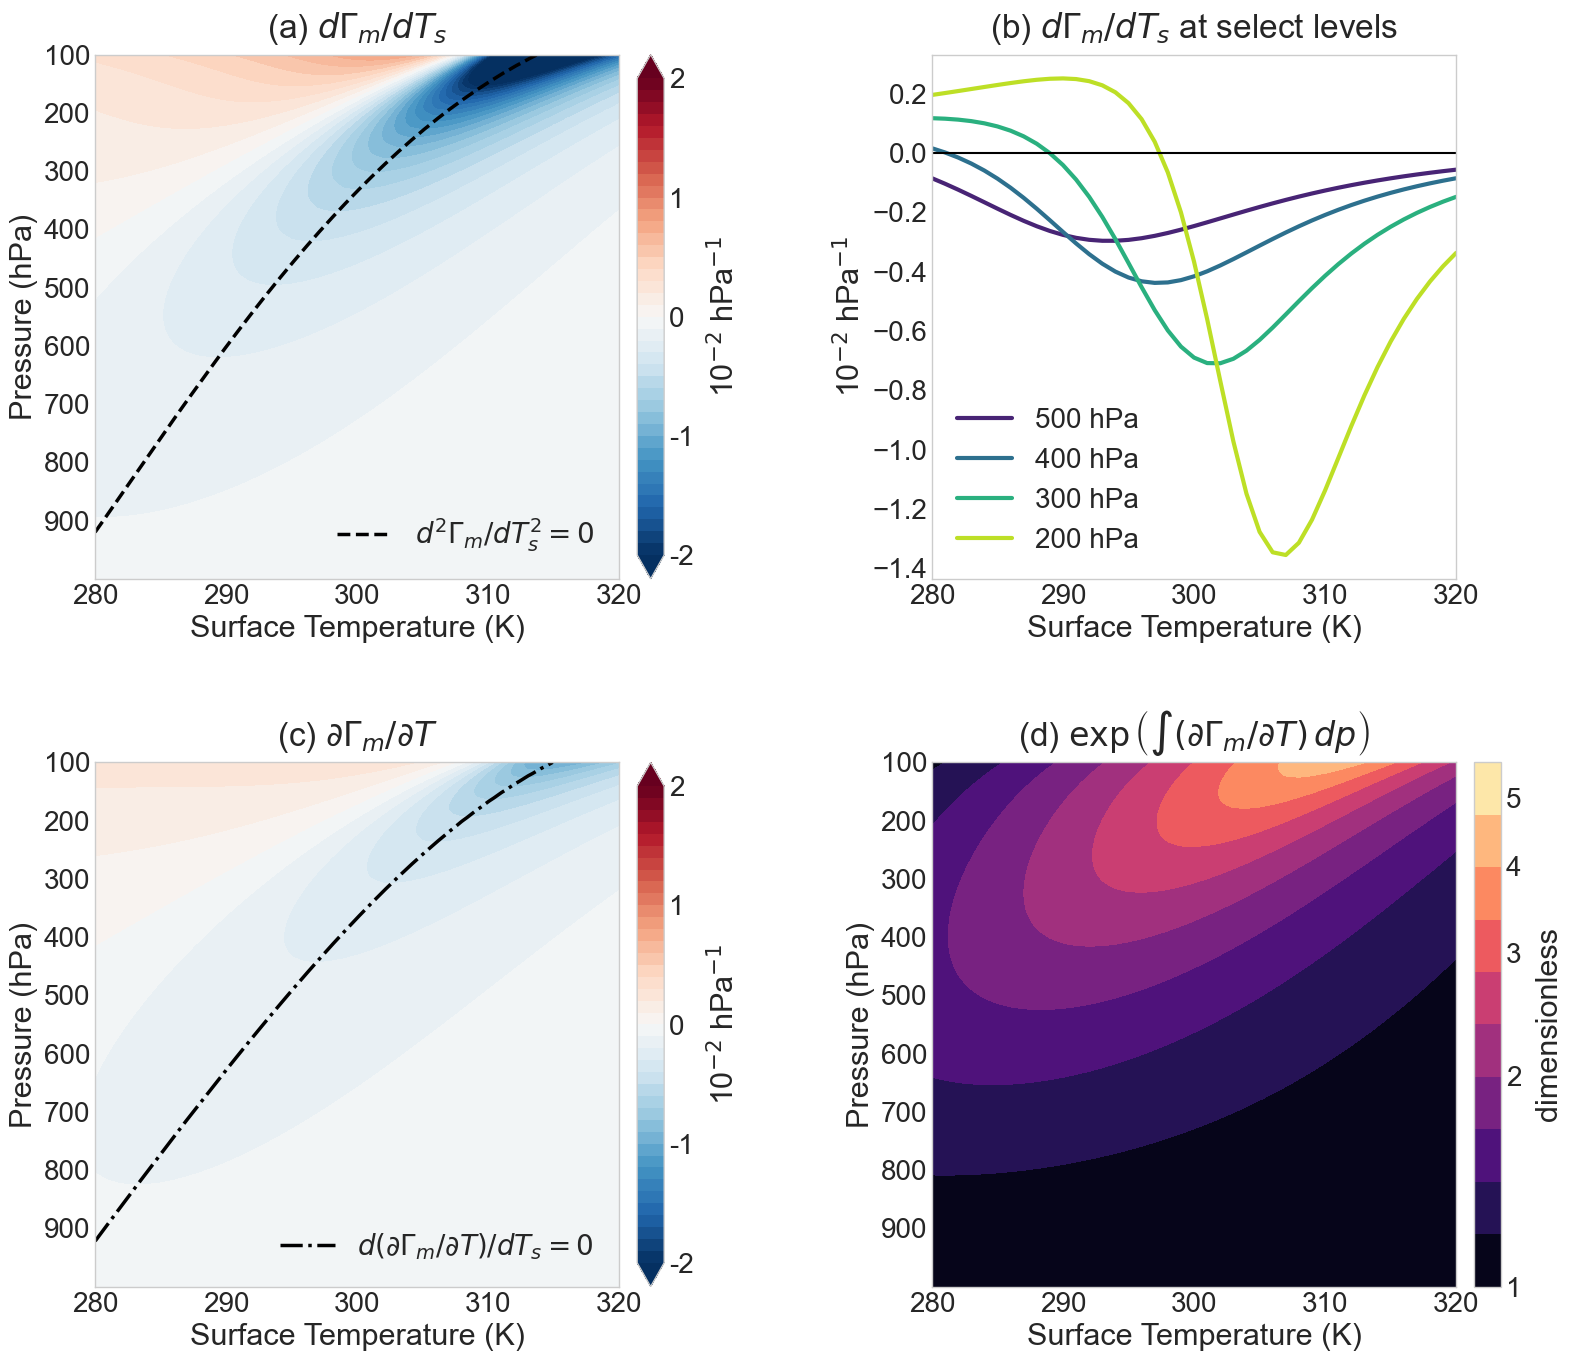

In [2]:
# ------------- PLOTTING (use only Ts ≥ 280 K) ----------------
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size':22,
    'axes.titlesize':24,
    'axes.labelsize':22,
    'xtick.labelsize':20,
    'ytick.labelsize':20,
    'legend.fontsize':20
})

p_hpa = p_grid / 100.0
# Slice fields to the visible range
T_plot    = T_surf_vals[plot_mask]
tot_plot  = total_sens_grid[:, plot_mask]
local_plot= local_sens_grid[:, plot_mask]
amp_plot  = amp_factor_grid[:, plot_mask]

Tmat, Pmat = np.meshgrid(T_plot, p_hpa)

# --- Get indices for line plots ---
p_levels_hpa = np.array([500, 400, 300, 200])
p_indices = [np.where(p_hpa == p)[0][0] for p in p_levels_hpa]
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(p_levels_hpa)))

# --- Colormaps and Levels ---
# Sensitivity scales (10^-4 K^-1 Pa^-1 or 10^-2 K^-1 hPa^-1)
scale_sens  = 1e4 # (Pa^-1) -> (100 * hPa)^-1 -> 100 * (100 Pa)^-1
limits_sens = 2
levels_sens = np.arange(-limits_sens, limits_sens+0.1, 0.1)
cmap_sens   = plt.get_cmap('RdBu_r')

# Amplification scales (log, dimensionless)
levels_log = np.logspace(0, 0.75, 11)
cmap_amp   = plt.get_cmap('magma')

# --- Figure & Gridspec (2x2) ---
fig = plt.figure(figsize=(18, 16))
gs  = GridSpec(2, 2, wspace=0.5, hspace=0.35)

axs = {
    'a': fig.add_subplot(gs[0, 0]),
    'b': fig.add_subplot(gs[0, 1]),
    'c': fig.add_subplot(gs[1, 0]),
    'd': fig.add_subplot(gs[1, 1]),
}

# Set aspect ratio for plots
axs['a'].set_box_aspect(1) # contour
axs['b'].set_box_aspect(1) # line
axs['c'].set_box_aspect(1) # contour
axs['d'].set_box_aspect(1) # contour


def draw(ax, Z, levels, cmap, title, label, log=False):
    if log:
        cf = ax.contourf(Tmat, Pmat, Z, levels=levels,
                         norm=LogNorm(vmin=levels[0], vmax=levels[-1]), cmap=cmap)
    else:
        cf = ax.contourf(Tmat, Pmat, Z, levels=levels, cmap=cmap, extend='both')
    ax.set_title(title, pad=12)
    ax.set_ylabel('Pressure (hPa)')
    ax.invert_yaxis()
    ax.set_ylim(1000,100)
    ax.set_yticks(np.arange(100, 1000, 100))
    ax.set_xlabel('Surface Temperature (K)')
    return cf

# --- Draw Panels ---
contours = {}
# Panel (a): Total Sensitivity (Contour)
contours['a'] = draw(axs['a'], tot_plot*scale_sens, levels_sens, cmap_sens,
                     '(a) $d\\Gamma_m/dT_s$',
                     '10$^{-2}$ hPa$^{-1}$')

# Panel (c): Local Sensitivity (Contour)
contours['c'] = draw(axs['c'], local_plot*scale_sens, levels_sens, cmap_sens,
                     '(c) $\\partial\\Gamma_m/\\partial T$',
                     '10$^{-2}$ hPa$^{-1}$')

# Panel (d): Amplification (Contour)
contours['d'] = draw(axs['d'], amp_plot, levels_log, cmap_amp,
                     '(d) $\\exp\left(\\int (\\partial\\Gamma_m/\\partial T)\\,dp\\right)$',
                     '(dimensionless)', log=True)

# --- Overlay Trough on Panel (a) ---
mask_T = np.isfinite(Ts_trough_root) & (Ts_trough_root >= Tmin_plot) & (Ts_trough_root <= 320.0)
axs['a'].plot(Ts_trough_root[mask_T], p_hpa[mask_T],
              color='k', lw=2.5, ls='--',
              label=r'$d^2\Gamma_m/dT_s^2 = 0$')
axs['a'].legend(loc='lower right')

# --- Overlay Trough on Panel (c) ---
mask_T_local = np.isfinite(Ts_trough_root_local) & (Ts_trough_root_local >= Tmin_plot) & (Ts_trough_root_local <= 320.0)
axs['c'].plot(Ts_trough_root_local[mask_T_local], p_hpa[mask_T_local],
              color='k', lw=2.5, ls='-.',
              label=r'$d(\partial\Gamma_m/\partial T)/d T_s = 0$')
axs['c'].legend(loc='lower right')


# --- Draw Panel (b) (Line Plot) ---
ax_b = axs['b']
for i, p_idx in enumerate(p_indices):
    label = f'{p_levels_hpa[i]:.0f} hPa'
    # Plot total sensitivity (dGamma_m / dTs)
    ax_b.plot(T_plot, tot_plot[p_idx, :] * scale_sens, label=label, color=colors[i], lw=3)

ax_b.set_title('(b) $d\\Gamma_m/dT_s$ at select levels', pad=12)
ax_b.set_xlabel('Surface Temperature (K)')
ax_b.set_ylabel('10$^{-2}$ hPa$^{-1}$')
ax_b.legend(loc='lower left')
ax_b.grid(False)
ax_b.axhline(0, color='k', ls='-', lw=1.5)
ax_b.set_xlim(T_plot[0], T_plot[-1])


# Tight layout before placing cbar axes
plt.tight_layout()
fig.canvas.draw()

# --- Colorbars ---
# Place colorbars for panels a, c, and d
cbar_width = 0.015
cbar_pad   = 0.01

# Dictionary of labels for colorbars
cbar_labels = {
    'a': '10$^{-2}$ hPa$^{-1}$',
    'c': '10$^{-2}$ hPa$^{-1}$', # was 'b'
    'd': 'dimensionless'  # was 'c'
}

# Note loop is for 'a', 'c', 'd'
for key in ['a', 'c', 'd']:
    ax = axs[key]
    pos = ax.get_position()
    # [left, bottom, width, height]
    cax = fig.add_axes([pos.x1 + cbar_pad, pos.y0, cbar_width, pos.height])
    cbar = fig.colorbar(contours[key], cax=cax, orientation='vertical')
    
    # Note check is for 'a', 'c'
    if key in ['a', 'c']:
        cbar.set_ticks([-2, -1, 0, 1, 2])
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    else:
        # This now applies to 'd'
        cbar.set_ticks([1.0, 2.0, 3.0, 4, 5])
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
        
    cbar.set_label(cbar_labels[key], labelpad=10)

plt.savefig("fig-2.png", dpi=600, bbox_inches='tight')
plt.show()